# Automatic Differentiation

Where do all these gradients come from?

<span class="column-margin margin-aside">*The code presented in this lecture is derived from Boaz Barak’s blog post “[Yet Another Backpropagation Tutorial](https://windowsontheory.org/2020/11/03/yet-another-backpropagation-tutorial/)” on his blog [Windows on Theory](https://windowsontheory.org/2020/11/03/yet-another-backpropagation-tutorial/). This code was in turn inspired by the [micrograd package](https://github.com/karpathy/micrograd) developed by Andrej Karpathy.*</span>

As we’ve hinted a few times in these notes so far, it is not necessary (or even possible) in modern machine learning to compute the gradients of functions by hand – rather, we can design efficient algorithms to achieve this for us. The computational technology that enables this is called *automatic differentiation*, sometimes also called *autodiff* or *autograd*.

### Motivating Example

To get things started, here’s an example of autograd in action. Consider the function

$$
\begin{aligned}
    \mathrm{MSE}(\mathbf{w}) = (y - w_1x - w_0)^2\;,
\end{aligned}
$$

which corresponds to the squared error loss for a simple linear regression model with parameters $\mathbf{w}= (w_0, w_1)$, input $x$, and target $y$.

In [ ]:
# TODO

If we wanted to compute the gradient of this function with respect to the parameters $\mathbf{w}$, we could do so by hand:

$$
\begin{aligned}
    \frac{\partial f}{\partial w_0} = -2(y - w_1x - w_0)\;,\quad
    \frac{\partial f}{\partial w_1} = -2x(y - w_1x - w_0)\;.
\end{aligned}
 \qquad(1)$$

In [ ]:
# TODO

At the point $\mathbf{w}= (1, 2)$, $x = 3$, and $y = 4$, for example, we have

$$
\begin{aligned}
    \frac{\partial \mathrm{MSE}}{\partial w_0} &= -2(4 - 2\cdot 3 - 1) = -2(-3) = 6\;,\quad \\
    \frac{\partial \mathrm{MSE}}{\partial w_1} &= -2\cdot 3(4 - 2\cdot 3 - 1) = -6(-3) = 18\;.
\end{aligned}
$$

Let’s check:

In [ ]:
import torch 
w = torch.tensor([1.0, 2.0])
x = 3.0
y = 4.0
# TODO

Looks good!

The work in this approach was primarily for the *human* – we had to compute the derivative by hand and then implement the result. Wouldn’t it be nice if we could instead get the derivatives we need without manual implementation? This is where automatic differentiation comes in:

In [ ]:
# TODO

We were able to find the same result without ever calling the `grad_f` function.

In the remainder of these notes, we’ll explore what `y.backward()` does by implementing a simple version of autograd ourselves.

## The Computational Graph

The key data structure for autograd is the *computational graph*.

<span class="theorem-title">**Definition 1 (Computational Graph)**</span> The computational graph of a function $f$ is a directed acyclic graph (DAG) in which the nodes correspond to intermediate values in the computation of $f$ and the edges correspond to the elementary operations that produce these values.

In the example of the MSE function above, we can decompose the computation into a sequence of operations as follows:

``` python
h1 = w[1]*x
h2 = w[0] + h1
h3 = y - h2
h4 = h3*h3
```

Here, the $h_i$ are the intermediate values in the computation of the MSE function. The computational graph for this function is shown in <a href="#fig-mse-computational-graph" class="quarto-xref">Figure 1</a>.

<figure id="fig-mse-computational-graph">
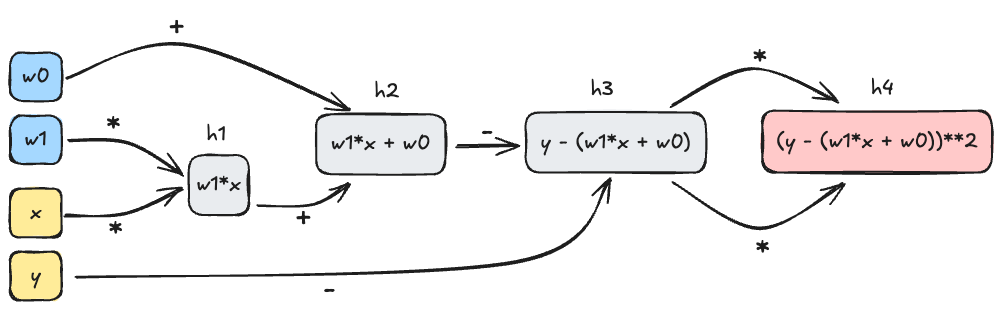
<figcaption>Figure 1: Computational graph for the one-point mean-squared error. The variables of optimization <span class="math inline"><em>w</em><sub>0</sub></span> and <span class="math inline"><em>w</em><sub>1</sub></span> are shown in blue, the data variables <span class="math inline"><em>x</em></span> and <span class="math inline"><em>y</em></span> are shown in yellow, intermediate values are shown in grey, and the final output is shown in red. Each edge is annotated with the operations that produce the value at the target node from the value at the source node.</figcaption>
</figure>

The key insight of automatic differentiation is that we can *store* the computational graph alongside the final output of the function, and then use that graph to compute the derivatives we need.

The key idea here is to start from the output node in the computational graph and work *backwards*. For example, let’s compute the gradient of the MSE function with respect to $w_0$ and $w_1$. We’ll start with the output node $h_4$ and work backwards, using the chain rule as we go.

$$
\begin{aligned}
    \frac{\partial h_4}{\partial h_3} &= 2h_3 &\quad \text{(since $h_4 = h_3^2$)} \\ 
    \frac{\partial h_4}{\partial h_2} &= \frac{\partial h_4}{\partial h_3}\times \frac{\partial h_3}{\partial h_2} = -2h_3 \times 1 &\quad \text{(since $h_3 = y - h_2$)}\\ 
    \frac{\partial h_4}{\partial h_1} &= \frac{\partial h_4}{\partial h_2}\times \frac{\partial h_2}{\partial h_1} = -2h_3 \times 1 &\quad \text{(since $h_2 = w_0 + h_1$)}\\ 
    \frac{\partial h_4}{\partial w_0} &= \frac{\partial h_4}{\partial h_2}\times \frac{\partial h_2}{\partial w_0} = -2h_3 \times 1 &\quad \text{(since $h_2 = w_0 + h_1$)}\\
    \frac{\partial h_4}{\partial w_1} &= \frac{\partial h_4}{\partial h_1}\times \frac{\partial h_1}{\partial w_1} = -2h_3 \times x\;. &\quad \text{(since $h_1 = w_1x$)}
\end{aligned}
$$

To check these results we just need to plug in the value of $h_3 = y - h_2 = y - (w_0 + w_1x)$, which matches <a href="#eq-mse-gradient" class="quarto-xref">Equation 1</a>. We have just worked our first example of *reverse-mode* automatic differentiation, which is the most common form of autograd used in machine learning.

<span class="theorem-title">**Definition 2 (Reverse-Mode Automatic Differentiation (Backpropagation))**</span> *Reverse-mode automatic differentiation* is a family of algorithms which computes the gradient $\nabla g(\mathbf{w}_0)$ of a function $g:\mathbb{R}^n\rightarrow \mathbb{R}$ with respect to its inputs $\mathbf{w}$ at $\mathbf{w}_0$ by starting from the output node of the computational graph, representing the value $g(\mathbf{w}_0)$, and working backwards towards the input nodes, applying the chain rule at each step.

The term *backpropagation* is also sometimes used to refer to reverse-mode automatic differentiation in the context of deep neural networks.

## Implementing Autograd

Let’s work on a simple toy implementation of reverse-mode automatic differentiation. Our goal here is to develop *enough* automatic differentiation that we can run a simple machine learning model from scratch.

The core of our implementation is a `Variable` class. A `Variable` has four main jobs:

1.  It holds a numerical value and a gradient value.  
2.  It remembers the `Variable`s which were used to compute it, and how they were used in the computation.
3.  It implements a `backward()` method which traverses the computational graph backwards from the `Variable`s location.
4.  It implements simple arithmetic operations and the derivative rules corresponding to those operations.

In [ ]:
# TODO

In [ ]:
def backward(self, visited = None): 

    if visited is None:
        visited= set([self])
        self.grad = 1

    self._backward()
    for child in self._prev:
        if not child in visited: 
            visited.add(child)
            child.backward(visited)

Variable.backward = backward # add the backward method to the Variable class

The remainder of the implementation of the `Variable` class is just a matter of implementing the arithmetic operations and their corresponding derivative rules. For example, here is the implementation of addition:

In [ ]:
# TODO

A key point here is that the gradients of `self` will be updated when `out`, the output of the addition operation, calls its `backward()` method. This means that the value of `out.grad` can flow to `self` and `other`, even though `self` and `other` are actually *first* in the computational graph. This is the sense in which reverse-mode automatic differentiation involves working *backwards* through the graph.

Here’s another example: multiplication. The implementation is almost the same, except this time we need to use the rules

$$
\begin{aligned}
    \frac{\partial (ab)}{\partial a} = b\;,\quad
    \frac{\partial (ab)}{\partial b} = a\;.
\end{aligned}
$$

to compute the local gradients for the multiplication operation:

In [ ]:
def __mul__(self, other): 
    other = other if isinstance(other, Variable) else Variable(other)
    out = Variable(self.data * other.data, (self, other))
    def _backward():
        d_out_d_self  = other.data
        d_out_d_other = self.data
        self.grad  += out.grad * d_out_d_self
        other.grad += out.grad * d_out_d_other
    out._backward = _backward
    return out

Before we are ready to use either of these methods, we need to add them to the `Variable` class:

In [ ]:
# TODO

It’s also very helpful to implement a few other operations, such as negation, subtraction, and exponentiation.

In [ ]:
# TODO

The last key method we need is one to zero out the gradients of a variable, which is necessary before we can call `backward()` again after an optimization step.

In [ ]:
# TODO

### A Quick Check

Let’s just check that our implementation of autograd is working as expected with a quick example:

In [ ]:
# TODO

Looks good!

Perhaps surprisingly, we are already able to implement linear regression using nothing but base Python and our `Variable` class. We need to use some slightly unusual syntax because, for example, we have implemented `Variable*int` but not `int*Variable`. We’re also relying on list copmrehensions, since we don’t have access to vectorized operations like those provided by NumPy or Torch.

In [ ]:
import random
from matplotlib import pyplot as plt
w0_true = -3.0
w1_true = 5.0
x = [Variable(0.01*val) for val in range(101)]
y = [Variable(x[i].data*w1_true + w0_true) + random.uniform(-1, 1) for i in range(101)]

Figure 2: A simple set of synthetic data for linear regression using manual autograd.

In [ ]:
fig, ax = plt.subplots()
ax.scatter([xi.data for xi in x], [yi.data for yi in y])
ax.set_xlabel(r'$x$')
t = ax.set_ylabel(r'$y$')

We’re going to construct yet another implementation of linear regression, again with a `forward` method. This time we’ll use our `Variable` class to compute the loss and its gradients, and then we’ll update the parameters using gradient descent.

In [ ]:
class LinearRegression: 
    def __init__(self): 
        self.w0 = Variable(0.0)
        self.w1 = Variable(0.0)

    # more complicated forward because we don't have access to vectorized operations
    def forward(self, x): 
        return [self.w1*x[i] + self.w0 for i in range(len(x))]

We can also implement the mean-squared error. This again is a bit more complicated because we don’t have vectorized operations in our autograd engine.

In [ ]:
# TODO

Now we can also implement a gradient descent optimizer. For the first time in these notes, our gradient descent optimizer *does not need to implement `grad_func`*: our hand-implemented automatic differentiation engine will handle that for us.

In [ ]:
class GradientDescentOptimizer: 
    def __init__(self, parameters, lr = 0.01): 
        self.parameters = parameters
        self.lr = lr

    def step(self): 
        for p in self.parameters:
            p.data -= self.lr*p.grad

    def zero_grad(self): 
        for p in self.parameters:
            p.zero_grad()

Now we can train our linear regression model using our autograd implementation and our gradient descent optimizer:

In [ ]:
# TODO

Let’s inspect the values we’ve learned:

In [ ]:
print(model.w0.data) # should be close to -3
print(model.w1.data) # should be close to 5

We’ve recovered parameters close to the expected ones, with no manual computation of derivatives! We can also visualize the fit of our model:

Figure 3: Visualization of data and the fitted linear regression model using manual autograd.

In [ ]:
fig, ax = plt.subplots()
ax.scatter([xi.data for xi in x], [yi.data for yi in y], label='data')
ax.plot([xi.data for xi in x], [model.w1.data*xi.data + model.w0.data for xi in x], color='black', label='model')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.legend()

## Autograd with Torch

We’re now ready to work with autograd in Torch. We can think of `torch.Tensor`s as a much more fully-worked version of the `Variable` class above, including differentiation rules that work with vectorized operations. This means that the fully idiomatic version of 1D linear regression in Torch would look something like this. The key ingredient here is the `requires_grad` flag, which tells Torch to store the computational graph for this variable and to compute gradients with respect to it when we call `backward()`.

In [ ]:
# linear regression class: very similar
class LinearRegression: 
    def __init__(self): 
        self.w0 = torch.tensor(0.0, requires_grad=True)
        self.w1 = torch.tensor(0.0, requires_grad=True)

    def forward(self, x): 
        return self.w1*x + self.w0

# mse can be vectorized -- torch will handle the gradients
def mse(y_pred, y):
    return torch.mean((y_pred - y)**2)

# x and y need to be converted to tensors for compatibility with autograd
x = torch.Tensor([x[i].data for i in range(len(x))])
y = torch.Tensor([y[i].data for i in range(len(y))])

model = LinearRegression()

# pre-implemented optimization algorithm: we'll see many more of these soon
optimizer = torch.optim.SGD([model.w0, model.w1], lr = 0.1)
for epoch in range(1000): 
    # forward pass
    y_pred = model.forward(x)
    # compute loss
    loss = mse(y_pred, y)
    # backward pass
    optimizer.zero_grad()
    loss.backward()
    # update parameters
    optimizer.step()

print(model.w0.data) # should be close to -3
print(model.w1.data) # should be close to 5

Of course, `torch` implements a very large number of mathematical operations and their corresponding differentiation rules, which allows us to use its autograd functionality for much more complex models. `torch` also implements various optimizations that make use of specialized hardware, especially including GPUs.

Now that we have built some understanding of autograd, we are ready to start using it freely. Liberal use of autograd will allow us to begin to consider models of arbitrary complexity, since we won’t have to worry about computing derivatives by hand. This is a key enabler towards deep learning – we can let the complexity of our models outstrip our ability to differentiate through them.